In [1]:
#!pip install graphdatascience

## Imports

In [2]:
# Data
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience

# Viz
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Setup

In [3]:
URI      = "neo4j://localhost:7687"
creds    = ('neo4j', 'pleaseletmein')
gds      = GraphDataScience(URI, auth=creds)

## Load CORA Data
#### Data from https://github.com/CJ2001

![](https://cdn-images-1.medium.com/fit/t/1600/480/1*oygeCjtUsS87duvFoDT8tA.png)

### Create Constraint

In [4]:
c = '''
// Create constraints
// CREATE CONSTRAINT papers IF NOT EXISTS ON (p:Paper) ASSERT p.id IS UNIQUE;
CREATE CONSTRAINT papers IF NOT EXISTS FOR (p:Paper) REQUIRE p.id IS UNIQUE;
'''

gds.run_cypher(c)

""


### Import Nodes

In [5]:
c = '''
// Load node list
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/JAChesney/KnowledgeGraph/main/data/cora_nodes.csv' AS line
WITH line
MERGE (p:Paper {id: line.id})
    ON CREATE SET p.subject = line.subject, p.features = line.features
RETURN COUNT(*)
'''

gds.run_cypher(c)

,COUNT(*)
0,2708


### Import Edges

In [6]:
c = '''
// Load edge list
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/JAChesney/KnowledgeGraph/main/data/cora_edges.csv' AS line
WITH line
MATCH (source:Paper {id: line.source})
MATCH (target:Paper {id: line.target})
MERGE (source)-[:CITES]->(target)
RETURN COUNT(*)
'''

gds.run_cypher(c)

,COUNT(*)
0,5429


## Create graph projection

In [8]:
# RUN THIS ONLY ONCE
node_projection = ["Paper"]
relationship_projection = {"CITES": {"orientation": "UNDIRECTED"}}
# G.drop() # when running again uncomment.

G, _ = gds.graph.project("papers", node_projection, relationship_projection)

In [9]:
def projection_stats(G):
    print('name:', G.name(), '\n')
    print('degree_distribution:\n', G.degree_distribution())
    print('density:', G.density(), '\n')
    print('node_count:', G.node_count())
    print('relationship_count:', G.relationship_count())

In [10]:
projection_stats(G)

name: papers 

degree_distribution:
 p99      19.000000
min       1.000000
max     169.000000
mean      4.009601
p90       7.000000
p50       3.000000
p999     74.000000
p95       9.000000
p75       5.000000
dtype: float64
density: 0.0014811973334628368 

node_count: 2708
relationship_count: 10858


## Stream FastRP Embeddings

In [11]:
# Run FastRP and mutate projection with result
result = gds.fastRP.stream(
    G,
    embeddingDimension=64,
    iterationWeights=[0.8, 1, 1, 1],
)

result.head()

,nodeId,embedding
0,0,"[0.5094364285469055, -0.1380840241909027, 0.11..."
1,1,"[-0.21760913729667664, 0.26321128010749817, -0..."
2,2,"[-0.37584543228149414, 0.25197553634643555, -0..."
3,3,"[-0.14327697455883026, 0.08559265732765198, 0...."
4,4,"[0.43408527970314026, -0.23349180817604065, -0..."


### Clean up Dataframe with Pandas transforms

In [12]:
df = pd.concat([result[['nodeId']],
                   pd.DataFrame.from_dict(dict(zip(result.embedding.index, result.embedding.values))).T],
                axis=1)
df.head()

,nodeId,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,0,0.509436,-0.138084,0.115770,-0.405454,0.537163,-0.110259,0.619507,0.140670,-0.201296,...,0.195389,-0.152611,-0.583051,0.260984,-0.522400,0.051242,-0.301052,-0.430126,0.740507,-0.396787
1,1,-0.217609,0.263211,-0.334593,-0.900127,-0.071374,0.210178,0.291188,0.340935,0.366088,...,-0.379835,0.433874,0.374659,0.274114,-0.727646,-0.089805,-0.089021,-0.324891,0.121753,-0.210930
2,2,-0.375845,0.251976,-0.024562,0.608495,-0.574377,-0.614595,0.432044,-0.044262,-0.358658,...,-0.034499,0.167943,-0.483793,-0.535888,0.478685,-0.265742,-0.325615,-0.240009,0.717497,-0.031474
3,3,-0.143277,0.085593,0.560531,0.438886,-0.276614,-0.039334,0.231872,0.059740,0.154369,...,-0.525809,0.215210,-0.473158,-0.593140,0.359757,-0.435562,0.109161,-0.039696,0.372078,0.396090
4,4,0.434085,-0.233492,-0.307766,0.026949,-0.293513,0.120243,0.477903,0.714382,0.350661,...,-0.151534,0.239194,0.095807,0.299940,-0.489535,-0.415224,0.245725,-0.521182,0.128456,-0.673309


In [13]:
df = pd.merge(gds.run_cypher('MATCH (n:Paper) RETURN id(n) as nodeId, n.subject as class'),
                df,
              on="nodeId")
df.head()

,nodeId,class,0,1,2,3,4,5,6,7,...,54,55,56,57,58,59,60,61,62,63
0,0,Neural_Networks,0.509436,-0.138084,0.115770,-0.405454,0.537163,-0.110259,0.619507,0.140670,...,0.195389,-0.152611,-0.583051,0.260984,-0.522400,0.051242,-0.301052,-0.430126,0.740507,-0.396787
1,1,Rule_Learning,-0.217609,0.263211,-0.334593,-0.900127,-0.071374,0.210178,0.291188,0.340935,...,-0.379835,0.433874,0.374659,0.274114,-0.727646,-0.089805,-0.089021,-0.324891,0.121753,-0.210930
2,2,Reinforcement_Learning,-0.375845,0.251976,-0.024562,0.608495,-0.574377,-0.614595,0.432044,-0.044262,...,-0.034499,0.167943,-0.483793,-0.535888,0.478685,-0.265742,-0.325615,-0.240009,0.717497,-0.031474
3,3,Reinforcement_Learning,-0.143277,0.085593,0.560531,0.438886,-0.276614,-0.039334,0.231872,0.059740,...,-0.525809,0.215210,-0.473158,-0.593140,0.359757,-0.435562,0.109161,-0.039696,0.372078,0.396090
4,4,Probabilistic_Methods,0.434085,-0.233492,-0.307766,0.026949,-0.293513,0.120243,0.477903,0.714382,...,-0.151534,0.239194,0.095807,0.299940,-0.489535,-0.415224,0.245725,-0.521182,0.128456,-0.673309


## Loop over desired algorithms and add them to Dataframe

In [14]:
for algo in ['pageRank', 'betweenness']:
    method = getattr(gds, algo)
    
    df = pd.merge(df, 
                    method.stream(G).rename(columns={'score': algo}),
                  on="nodeId")
df.head()

,nodeId,class,0,1,2,3,4,5,6,7,...,56,57,58,59,60,61,62,63,pageRank,betweenness
0,0,Neural_Networks,0.509436,-0.138084,0.115770,-0.405454,0.537163,-0.110259,0.619507,0.140670,...,-0.583051,0.260984,-0.522400,0.051242,-0.301052,-0.430126,0.740507,-0.396787,0.971196,0.500000
1,1,Rule_Learning,-0.217609,0.263211,-0.334593,-0.900127,-0.071374,0.210178,0.291188,0.340935,...,0.374659,0.274114,-0.727646,-0.089805,-0.089021,-0.324891,0.121753,-0.210930,0.318668,0.000000
2,2,Reinforcement_Learning,-0.375845,0.251976,-0.024562,0.608495,-0.574377,-0.614595,0.432044,-0.044262,...,-0.483793,-0.535888,0.478685,-0.265742,-0.325615,-0.240009,0.717497,-0.031474,0.749227,742.050666
3,3,Reinforcement_Learning,-0.143277,0.085593,0.560531,0.438886,-0.276614,-0.039334,0.231872,0.059740,...,-0.473158,-0.593140,0.359757,-0.435562,0.109161,-0.039696,0.372078,0.396090,0.632337,101.481038
4,4,Probabilistic_Methods,0.434085,-0.233492,-0.307766,0.026949,-0.293513,0.120243,0.477903,0.714382,...,0.095807,0.299940,-0.489535,-0.415224,0.245725,-0.521182,0.128456,-0.673309,0.442147,0.000000


## Create Pandas Plot

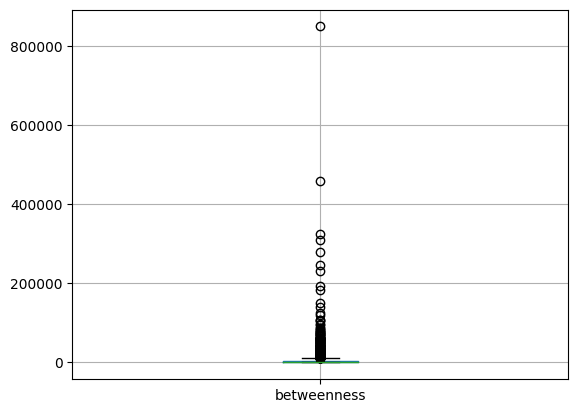

In [15]:
boxplot = df.boxplot(column=['betweenness'])
plt.show()

## Create Seaborn Plot

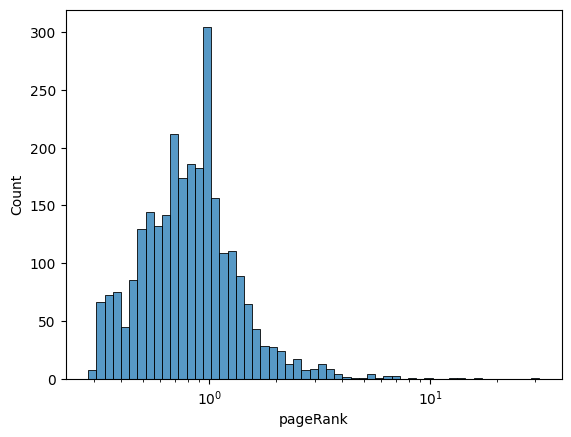

In [16]:
sns.histplot(df['pageRank'], log_scale=True)
plt.show()

## Visualize FastRP embeddings with TSNE plot

In [17]:
def create_tsne_plot(df):

    X_emb = TSNE(n_components=2).fit_transform(df[df.columns[2:-3]])

    tsne_df = pd.DataFrame(data = {
        'x': [value[0] for value in X_emb],
        'y': [value[1] for value in X_emb], 
        'label': pd.factorize(df['class'])[0].astype("float32")
    })

    plt.figure(figsize=(16,10))
    s = 30
    ax = sns.scatterplot(
        x='x', y='y',
        palette=sns.color_palette('hls', 7),
        data=tsne_df,
        hue='label',
        legend=True, 
        s=100,
        alpha=0.75
    )
    ax.legend(prop={'size': 10})
    plt.xlabel('X Component', fontsize=16)
    plt.ylabel('Y Component', fontsize=16)
    plt.show()

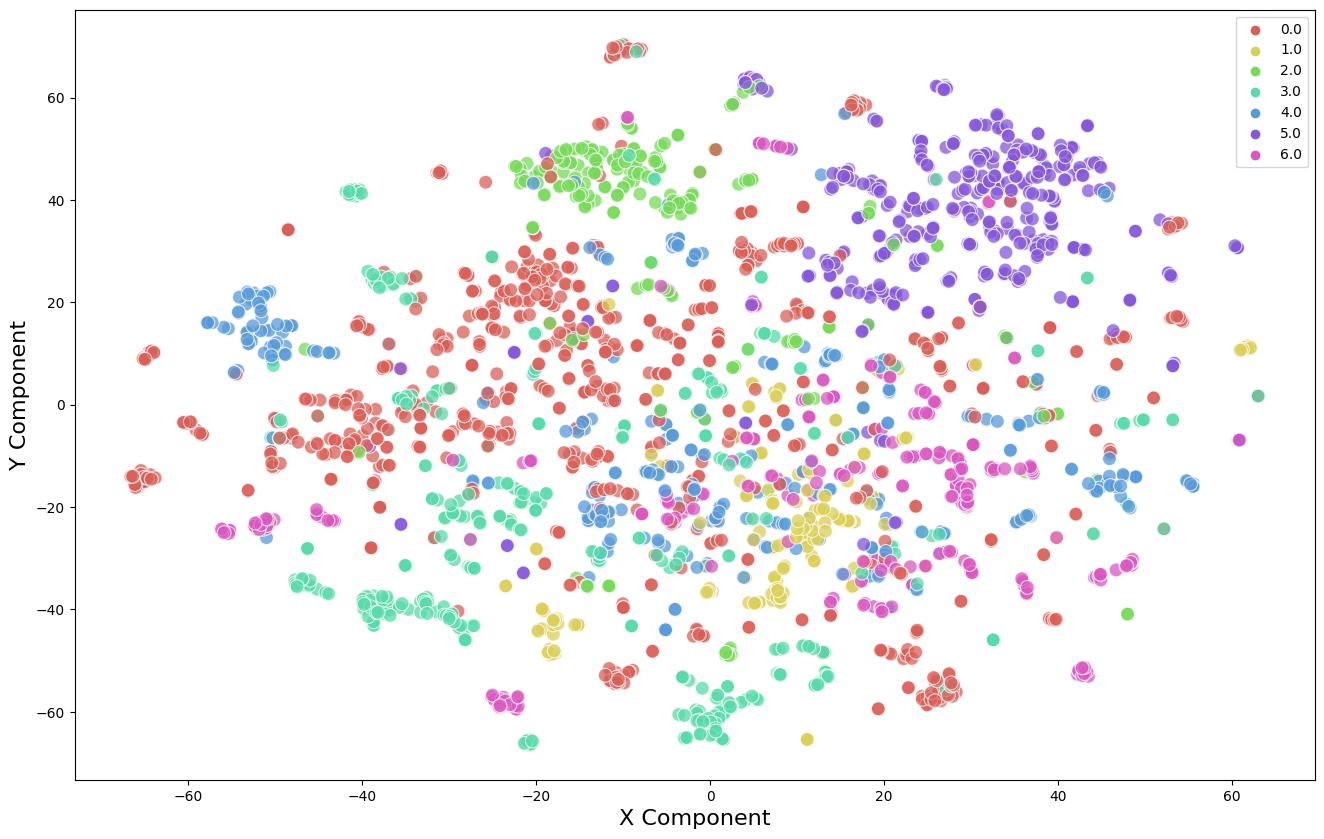

In [18]:
create_tsne_plot(df)

## Split Train & Test Data

In [19]:
encoder = LabelEncoder()
encoder.fit(df['class'])

df['class'] = encoder.transform(df['class'])


In [20]:
np.random.seed(42)

X = df[df.columns[2:-3]]  # Features
y = df['class']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

## Build Classifier

In [21]:
#Create a Gaussian Classifier

clf = XGBClassifier(n_estimators=100,
                    use_label_encoder=False,
                    eval_metric='mlogloss')

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

c:\Users\Jason_Chesney\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


## Classifier Metrics

In [22]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8253382533825339


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.64      0.72        95
           1       0.91      0.93      0.92       118
           2       0.84      0.89      0.87       254
           3       0.81      0.87      0.84       123
           4       0.82      0.82      0.82        56
           5       0.79      0.76      0.77        58
           6       0.74      0.70      0.72       109

    accuracy                           0.83       813
   macro avg       0.82      0.80      0.81       813
weighted avg       0.82      0.83      0.82       813



In [24]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
# matrix = ConfusionMatrixDisplay(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')


In [25]:
matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

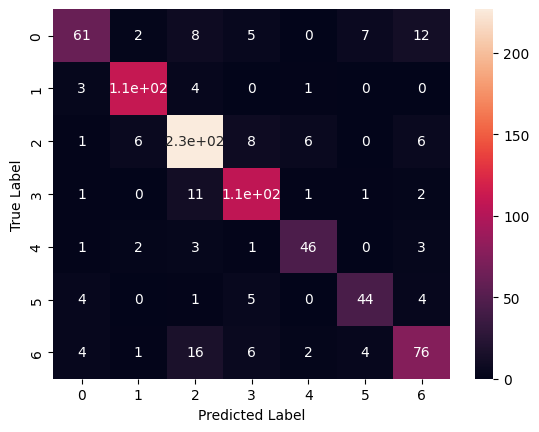

In [29]:
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

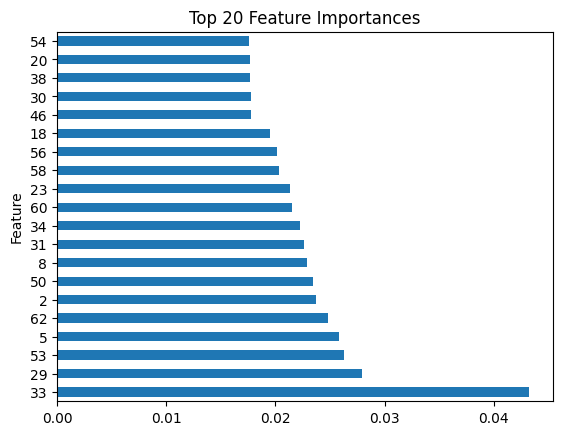

In [28]:
top_n = 20

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(top_n).plot(kind='barh', 
                                      title=f'Top {top_n} Feature Importances',
                                      ylabel= 'Feature')
plt.show()